In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from losses import nll_logistic_hazard
from model import MLP
from utils import MyDataset
from transforms import Transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)

df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [4]:
#Train
train_trans = Transforms()
df_train , y_train = train_trans.modify_data(data = df_train , dur_col = 'duration' , eve_col = 'event' , cuts = 10)
print(f'indices {train_trans.bucket_indices}')

#Val
val_trans = Transforms()
df_val , y_val = val_trans.modify_data(data = df_val , dur_col = 'duration' , eve_col = 'event' , cuts = 10)
# print(f'indices {val_trans.bucket_indices}')

#Test
test_trans = Transforms()
df_test , y_test = test_trans.modify_data(data = df_test , dur_col = 'duration' , eve_col = 'event' , cuts = 10)
# print(f'indices {test_trans.bucket_indices}')

indices [3 3 7 ... 1 6 4]


In [5]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

# num_durations = 10

# labtrans = LogisticHazard.label_transform(num_durations)
# # labtrans = PMF.label_transform(num_durations)
# # labtrans = DeepHitSingle.label_transform(num_durations)

# get_target = lambda df: (df['duration'].values, df['event'].values)
# y_train = labtrans.fit_transform(*get_target(df_train))
# y_val = labtrans.transform(*get_target(df_val))

# train = (x_train, y_train)
# val = (x_val, y_val)

# We don't need to transform the test labels
# durations_test, events_test = get_target(df_test)

In [8]:
# Hyper Params
input_size = x_train.shape[1]
hidden_size = 32
output_size = train_trans.bucket_indices
# batch_norm = True
dropout = 0.1
learning_rate = 0.01
num_epochs = 100

# Convert dtypes
dur_idx = torch.Tensor(y_train[0].astype('int'))
events = torch.Tensor(y_train[1].astype('int') )

dur_idx_val = torch.Tensor(y_val[0].astype('int'))
events_val = torch.Tensor(y_val[1].astype('int') )

# # Define early stopping parameters
# patience = 10
# best_loss = float('inf')
# counter = 0

# # init model
# model = MLP(input_size , hidden_size , output_size , dropout_rate = dropout)

# # init optim
# optimizer = torch.optim.Adam(model.parameters() , lr = learning_rate)

# # Create an instance of your custom dataset
# dataset = MyDataset(x_train, dur_idx, events)

# # Create a data loader for batching and shuffling
# batch_size = 256
# shuffle = True
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [7]:
# Training loop
for epoch in range(num_epochs):
    for batch_id , (cov , dur , eve) in enumerate(dataloader):
        # Prime for training
        model.train()
        
        # forward pass
        phi_train = model(torch.Tensor(cov))

        # get loss
        loss = nll_logistic_hazard(phi_train , dur , eve)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Prime for evaluation
        model.eval()
        with torch.no_grad():
            phi_val = model(torch.Tensor(x_val))
            val_loss = nll_logistic_hazard(phi_val, dur_idx_val , events_val)
        
        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

        print(f"Epoch {epoch+1}: Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}") 

# turn training off
model.eval()

Epoch 1: Training Loss: 3.2578, Validation Loss: 3.2015
Epoch 1: Training Loss: 3.2343, Validation Loss: 3.1207
Epoch 1: Training Loss: 3.0926, Validation Loss: 3.0546
Epoch 1: Training Loss: 3.0426, Validation Loss: 2.9939
Epoch 1: Training Loss: 3.1451, Validation Loss: 2.9308
Epoch 2: Training Loss: 2.8753, Validation Loss: 2.8721
Epoch 2: Training Loss: 2.8383, Validation Loss: 2.8115
Epoch 2: Training Loss: 2.8314, Validation Loss: 2.7509
Epoch 2: Training Loss: 2.7731, Validation Loss: 2.6889
Epoch 2: Training Loss: 2.6208, Validation Loss: 2.6235
Epoch 3: Training Loss: 2.6679, Validation Loss: 2.5574
Epoch 3: Training Loss: 2.4126, Validation Loss: 2.4879
Epoch 3: Training Loss: 2.5633, Validation Loss: 2.4175
Epoch 3: Training Loss: 2.4713, Validation Loss: 2.3392
Epoch 3: Training Loss: 2.3484, Validation Loss: 2.2652
Epoch 4: Training Loss: 2.3241, Validation Loss: 2.1894
Epoch 4: Training Loss: 2.2049, Validation Loss: 2.1174
Epoch 4: Training Loss: 2.1018, Validation Loss:

MLP(
  (network): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [8]:
#testing
hazards = torch.sigmoid(model(torch.Tensor(x_test)))
survival = torch.cumprod(1 - hazards , dim = 1)

In [9]:
hazards[:1].shape

torch.Size([1, 10])

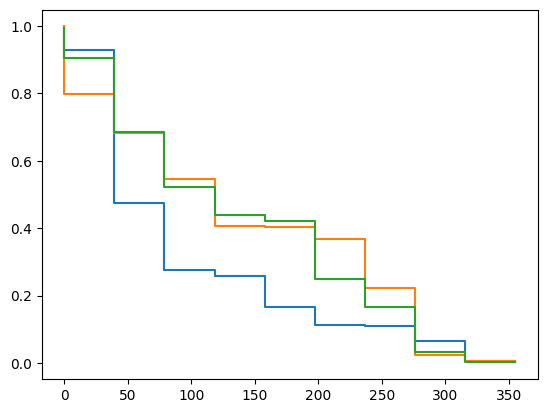

In [10]:
for surv in survival[:3]:
    plt.step(labtrans.cuts , surv.detach().numpy());